In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dir = "/content/drive/MyDrive/DataSkola/Tugas F P"
os.chdir(dir)

In [3]:
!ls

'Copy of Tugas Final Project.ipynb'   model_lgb.pkl   term_deposit.csv	'Tugas Final Project.ipynb'


#Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    cross_val_score
)

import warnings
warnings.simplefilter(action="ignore")
import pickle

#Load the dataset

We get the dataset from [Kaggle](https://www.kaggle.com/datasets/aslanahmedov/predict-term-deposit/)

In [5]:
df = pd.read_csv('term_deposit.csv')

In [6]:
print(df.shape)
df.head()

(45211, 18)


,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


#Data Understanding

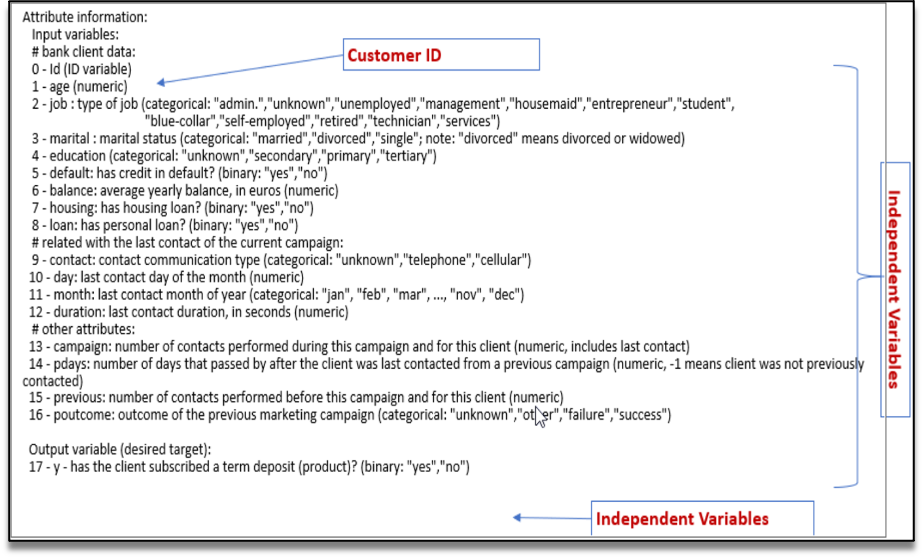

Bank has multiple banking products that it sells to customer such as saving account, credit cards, investments etc. It wants to which customer will purchase its credit cards. For the same it has various kind of information regarding the demographic details of the customer, their banking behavior etc. Once it can predict the chances that customer will purchase a product, it wants to use the same to make pre-payment to the authors. In this analysis, we wil predict if a client will subscribe (yes/no) to a term deposit — this is defined as a classification problem.

#Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45202 non-null  float64
 2   job        45211 non-null  object 
 3   marital    45211 non-null  object 
 4   education  45211 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   contact    45211 non-null  object 
 10  day        45211 non-null  int64  
 11  month      45211 non-null  object 
 12  duration   45211 non-null  int64  
 13  campaign   45211 non-null  int64  
 14  pdays      45211 non-null  int64  
 15  previous   45211 non-null  int64  
 16  poutcome   45211 non-null  object 
 17  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(10)
memory usage: 6.2+ MB


In [8]:
df.describe()

,Id,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45202.000000,45208.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,23606.000000,40.954714,1362.346620,15.806419,258.163080,2.763841,40.197828,0.580323
std,13051.435847,11.539144,3044.852387,8.322476,257.527812,3.098021,100.128746,2.303441
min,1001.000000,-1.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,12303.500000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,23606.000000,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,34908.500000,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,46211.000000,999.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
df.isna().sum()

Id           0
age          9
job          0
marital      0
education    0
default      0
balance      3
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [10]:
# Remove row of missing value
df.dropna(inplace=True)

In [11]:
# Column 'Id' doesn't give any value, so it'll be dropped
df = df.drop('Id', axis=1)

In [12]:
# List of categorical variables
categorical_var = df.select_dtypes(exclude="number")
categorical_var.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


In [13]:
# List of numerical variables
numerical_var = df.select_dtypes(include="number")
numerical_var.head()

,age,balance,day,duration,campaign,pdays,previous
0,999.0,2143.0,5,261,1,-1,0
1,44.0,29.0,5,151,1,-1,0
2,33.0,2.0,5,76,1,-1,0
3,47.0,1506.0,5,92,1,-1,0
4,33.0,1.0,5,198,1,-1,0


#Data Visualization

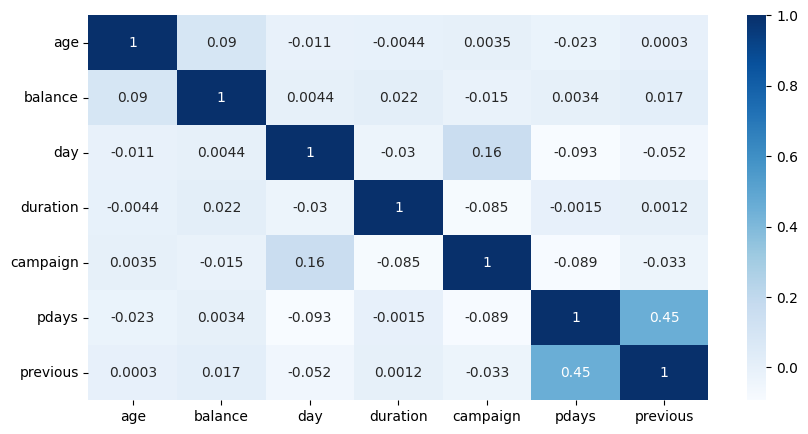

In [14]:
plt.figure(figsize=(10, 5))

sns.heatmap(
    df.corr(),
    cmap='Blues',
    annot=True
);

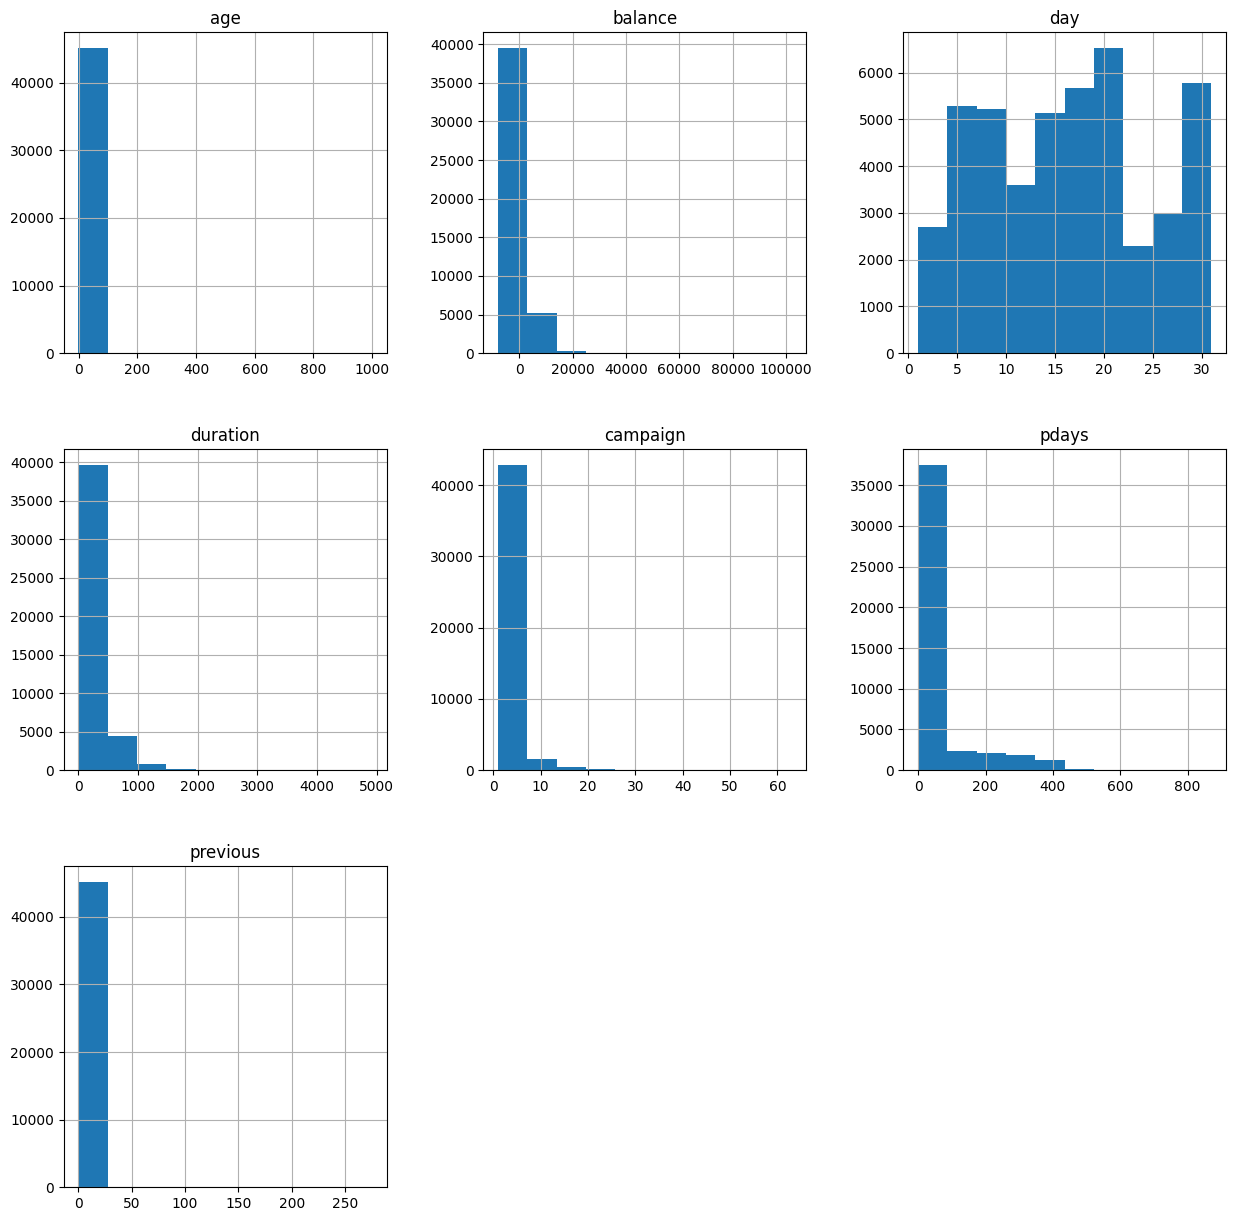

In [15]:
# see how the data is distributed.
df.hist(figsize = (15,15));

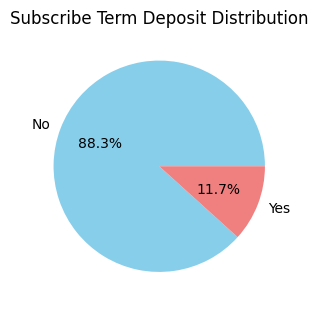

In [16]:
# Menghitung jumlah data pada setiap kategori "y"
y_counts = df['y'].value_counts()

# Membuat diagram lingkaran (pie chart)
plt.figure(figsize=(3, 3.5))
plt.pie(
    y_counts,
    labels=['No', 'Yes'],
    autopct='%1.1f%%',
    colors=['skyblue', 'lightcoral']
  )
plt.title("Subscribe Term Deposit Distribution")
plt.axis('equal')  # Memastikan diagram lingkaran berbentuk lingkaran
plt.show()

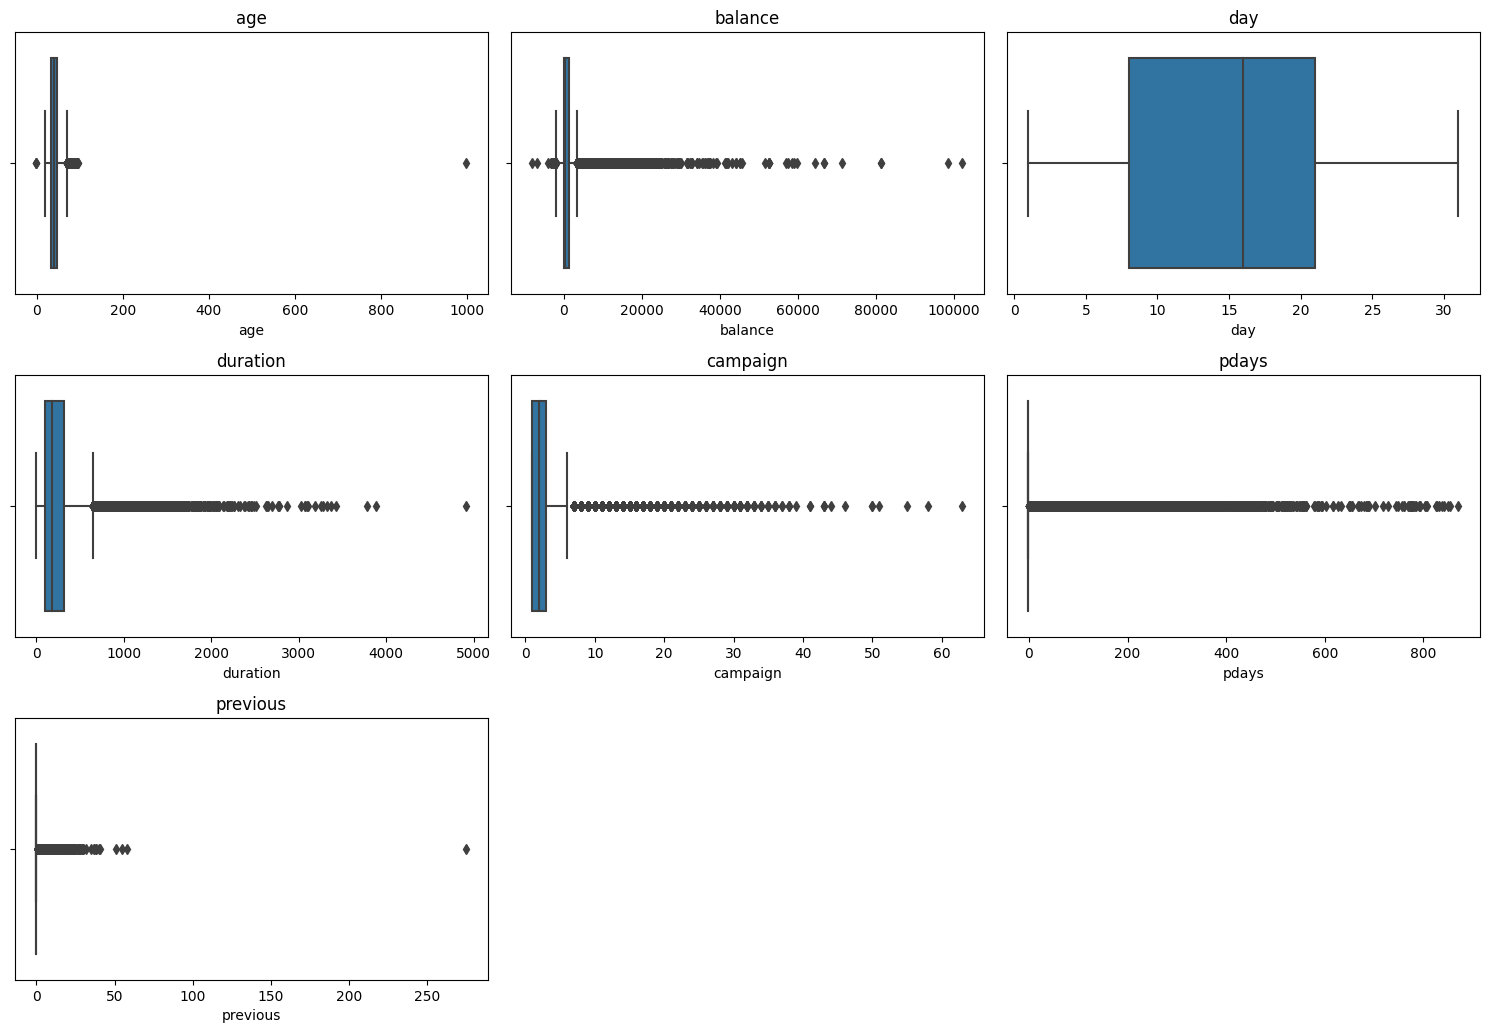

In [17]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_var):
    plt.subplot(3, 3, i % 9 + 1)  # Adjust the 3x3 grid layout
    sns.boxplot(x=numerical_var[col])
    plt.title(col)

    if i % 3 == 2 or i == len(numerical_var) - 1:
        plt.tight_layout()

plt.show()

#Data Preprocessing

##Outlier

In [18]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [19]:
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")

In [20]:
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
for col in numerical_var.columns:
    has_outliers(numerical_var, col)

age yes
balance yes
duration yes
campaign yes
pdays yes
previous yes


In [22]:
replace_with_thresholds(numerical_var, numerical_var.columns)

In [23]:
for col in numerical_var.columns:
    has_outliers(numerical_var, col)

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45200.0,40.954292,11.539117,-1.0,33.0,39.0,48.0,999.0
balance,45200.0,1362.565686,3045.076372,-8019.0,72.0,449.0,1428.0,102127.0
day,45200.0,15.809049,8.321781,1.0,8.0,16.0,21.0,31.0
duration,45200.0,258.141637,257.438318,0.0,103.0,180.0,319.0,4918.0
campaign,45200.0,2.764270,3.098276,1.0,1.0,2.0,3.0,63.0
pdays,45200.0,40.207854,100.138866,-1.0,-1.0,-1.0,-1.0,871.0
previous,45200.0,0.580465,2.303704,0.0,0.0,0.0,0.0,275.0


In [25]:
df = df[df['age']>= 18]
df = df[df['age']< 80]

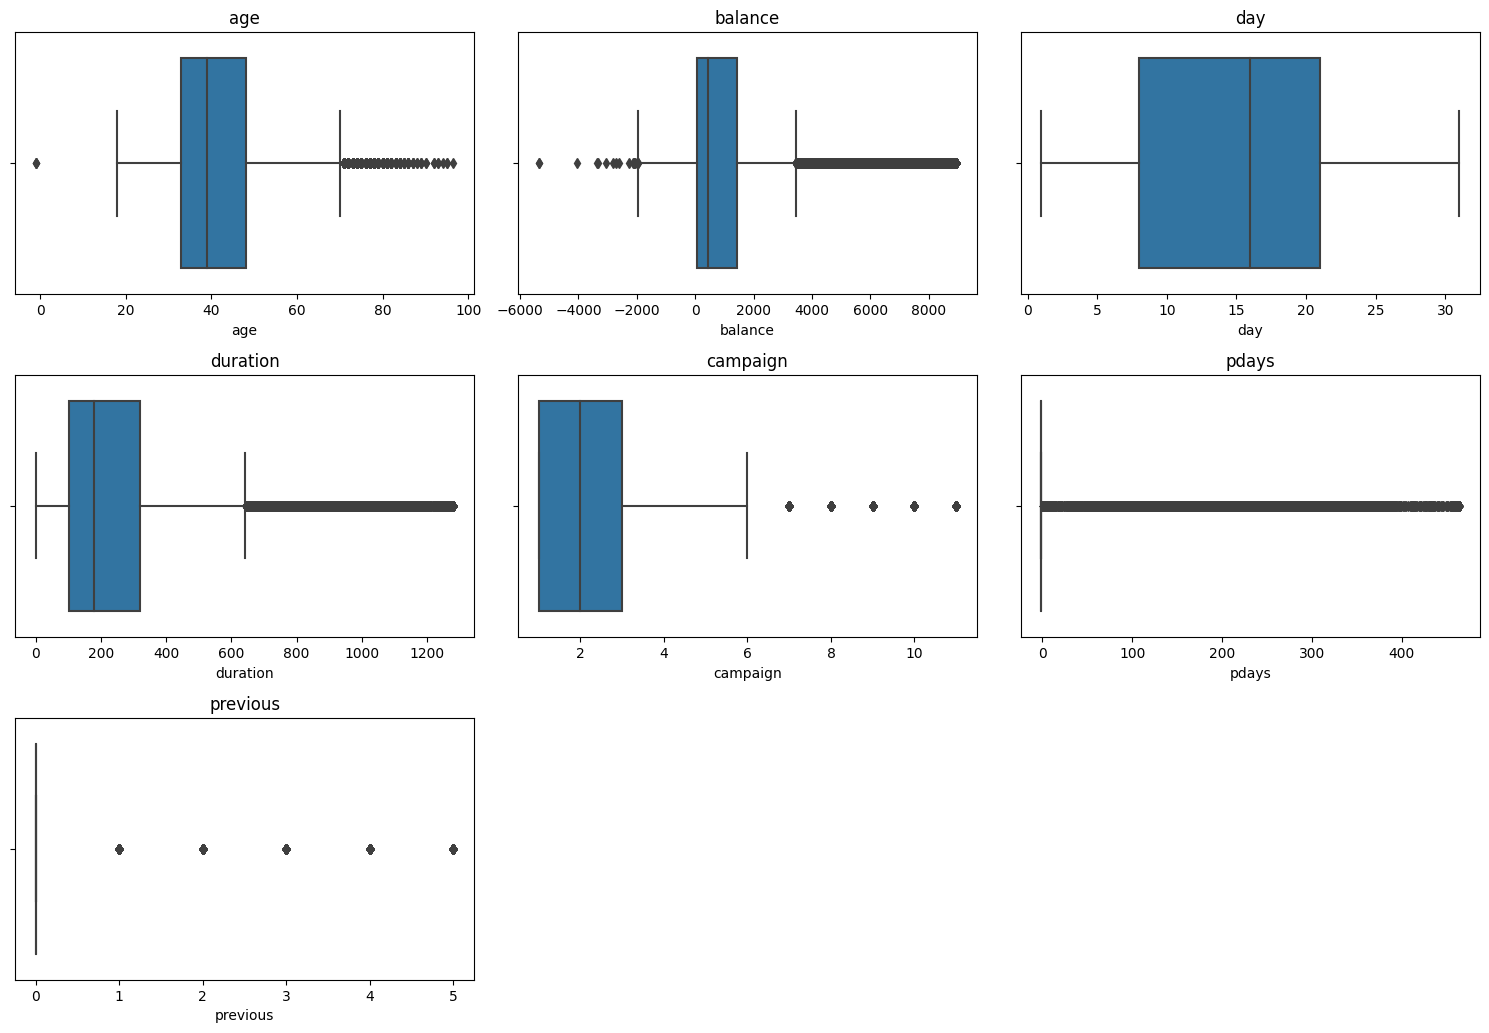

In [26]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_var):
    plt.subplot(3, 3, i % 9 + 1)  # Adjust the 3x3 grid layout
    sns.boxplot(x=numerical_var[col])
    plt.title(col)

    if i % 3 == 2 or i == len(numerical_var) - 1:
        plt.tight_layout()

plt.show()

In [27]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5,may,139,1,-1,0,unknown,no


##Encoding

In [28]:
encoder = LabelEncoder()

In [29]:
print('Categorical Variables:', categorical_var.columns)
print('--------------------------------')
print('Numerical Variables:', numerical_var.columns)

Categorical Variables: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')
--------------------------------
Numerical Variables: Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [30]:
df['job'] = encoder.fit_transform(df['job'])
job = {index : label for index, label in enumerate(encoder.classes_)}
job

{0: 'admin.',
 1: 'blue-collar',
 2: 'entrepreneur',
 3: 'housemaid',
 4: 'management',
 5: 'retired',
 6: 'self-employed',
 7: 'services',
 8: 'student',
 9: 'technician',
 10: 'unemployed',
 11: 'unknown'}

In [31]:
df['marital'] = encoder.fit_transform(df['marital'])
marital = {index : label for index, label in enumerate(encoder.classes_)}
marital

{0: 'divorced', 1: 'married', 2: 'single'}

In [32]:
df['education'] = encoder.fit_transform(df['education'])
education = {index : label for index, label in enumerate(encoder.classes_)}
education

{0: 'primary', 1: 'secondary', 2: 'tertiary', 3: 'unknown'}

In [33]:
df['default'] = encoder.fit_transform(df['default'])
default = {index : label for index, label in enumerate(encoder.classes_)}
default

{0: 'no', 1: 'yes'}

In [34]:
df['housing'] = encoder.fit_transform(df['housing'])
housing = {index : label for index, label in enumerate(encoder.classes_)}
housing

{0: 'no', 1: 'yes'}

In [35]:
df['loan'] = encoder.fit_transform(df['loan'])
loan = {index : label for index, label in enumerate(encoder.classes_)}
loan

{0: 'no', 1: 'yes'}

In [36]:
df['contact'] = encoder.fit_transform(df['contact'])
contact = {index : label for index, label in enumerate(encoder.classes_)}
contact

{0: 'cellular', 1: 'telephone', 2: 'unknown'}

In [37]:
df['month'] = df['month'].map(
    {'jan':1,'feb':2,'mar':3,'apr':4,
     'may':5,'jun':6,'jul':7,'aug':8,
     'sep':9,'oct':10,'nov':11,'dec':12}
)

In [38]:
df['poutcome'] = encoder.fit_transform(df['poutcome'])
poutcome = {index : label for index, label in enumerate(encoder.classes_)}
poutcome

{0: 'failure', 1: 'other', 2: 'success', 3: 'unknown'}

In [39]:
df['y'] = (df.y == 'yes').astype('int')

In [40]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,44.0,9,2,1,0,29.0,1,0,2,5,5,151,1,-1,0,3,0
2,33.0,2,1,1,0,2.0,1,1,2,5,5,76,1,-1,0,3,0
3,47.0,1,1,3,0,1506.0,1,0,2,5,5,92,1,-1,0,3,0
4,33.0,11,2,3,0,1.0,0,0,2,5,5,198,1,-1,0,3,0
5,35.0,4,1,2,0,231.0,1,0,2,5,5,139,1,-1,0,3,0


##Scaling

In [41]:
columns_to_be_scale = df.columns.drop('y')

In [42]:
# scaling numerical columns
scaler = StandardScaler()
scaler.fit(df[columns_to_be_scale])
data_to_be_scale = scaler.transform(df[columns_to_be_scale])
columns_value_new = df[columns_to_be_scale].columns
data_scaled = pd.DataFrame(data_to_be_scale, columns = columns_value_new)
data_scaled.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0.306803,1.422610,1.366887,-0.303030,-0.135627,-0.442904,0.891123,-0.437532,1.513222,-1.299171,-0.475402,-0.415521,-0.569633,-0.411042,-0.251302,0.444421
1,-0.752417,-0.713519,-0.277801,-0.303030,-0.135627,-0.451905,0.891123,2.285547,1.513222,-1.299171,-0.475402,-0.706974,-0.569633,-0.411042,-0.251302,0.444421
2,0.595681,-1.018681,-0.277801,2.375734,-0.135627,0.049477,0.891123,-0.437532,1.513222,-1.299171,-0.475402,-0.644797,-0.569633,-0.411042,-0.251302,0.444421
3,-0.752417,2.032933,1.366887,2.375734,-0.135627,-0.452239,-1.122180,-0.437532,1.513222,-1.299171,-0.475402,-0.232877,-0.569633,-0.411042,-0.251302,0.444421
4,-0.559832,-0.103197,-0.277801,1.036352,-0.135627,-0.375564,0.891123,-0.437532,1.513222,-1.299171,-0.475402,-0.462153,-0.569633,-0.411042,-0.251302,0.444421


In [43]:
# merge y
data1 = df.drop(columns_to_be_scale, axis =1)
df2 = pd.concat([data_scaled, data1], axis=1, join='inner')
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,-0.752417,-0.713519,-0.277801,-0.303030,-0.135627,-0.451905,0.891123,2.285547,1.513222,-1.299171,-0.475402,-0.706974,-0.569633,-0.411042,-0.251302,0.444421,0
2,0.595681,-1.018681,-0.277801,2.375734,-0.135627,0.049477,0.891123,-0.437532,1.513222,-1.299171,-0.475402,-0.644797,-0.569633,-0.411042,-0.251302,0.444421,0
3,-0.752417,2.032933,1.366887,2.375734,-0.135627,-0.452239,-1.122180,-0.437532,1.513222,-1.299171,-0.475402,-0.232877,-0.569633,-0.411042,-0.251302,0.444421,0
4,-0.559832,-0.103197,-0.277801,1.036352,-0.135627,-0.375564,0.891123,-0.437532,1.513222,-1.299171,-0.475402,-0.462153,-0.569633,-0.411042,-0.251302,0.444421,0
5,-1.233881,-0.103197,1.366887,1.036352,-0.135627,-0.303557,0.891123,2.285547,1.513222,-1.299171,-0.475402,-0.159042,-0.569633,-0.411042,-0.251302,0.444421,0


##Splitting

In [44]:
# After a few tries on machine learning, we chose to not use skaling data
# Because the scaled model prediction accuracy is really weird

x = df.drop(columns=['y'])
y = df.filter(['y'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.2,
    random_state=42
)

##SMOTE

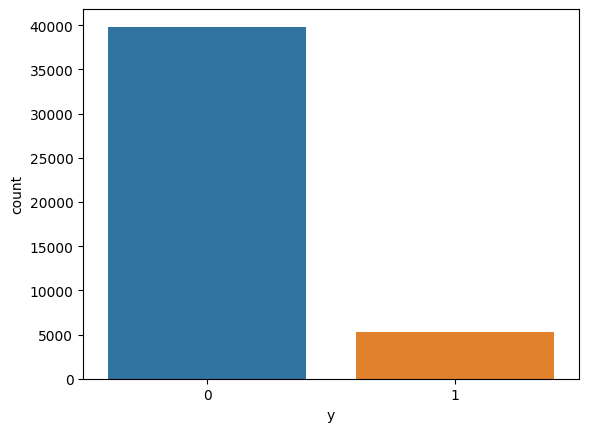

In [45]:
# Checking imbalance data
sns.countplot(x='y', data=df)
plt.show()

In [46]:
# creating an instance
sm = SMOTE(random_state=42)
# applying it to the training set
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

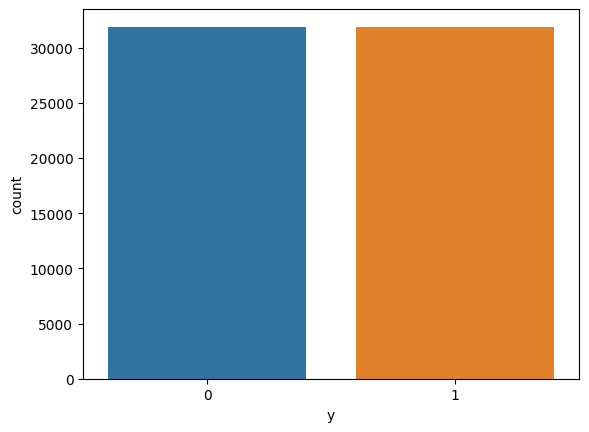

In [47]:
# Checking imbalance data
sns.countplot(x='y', data=y_train_s)
plt.show()

#Modelling

In [48]:
def basic_model(model, x_train, y_train):
  """
  Executing the machine learning model
  as a benchmark
  """
  clf = model
  return clf.fit(x_train, y_train)

In [49]:
def evaluation(model, x_train, x_test, y_train, y_test):
  """
  evaluate the model
  """
  clf = model

  y_predict_train = clf.predict(x_train)
  y_predict_test = clf.predict(x_test)

  training_acc = accuracy_score(y_train, y_predict_train)
  testing_acc = accuracy_score(y_test, y_predict_test)

  print("Training Accuracy: {:.2}".format(training_acc))
  print("Testing Accuracy: {:.2}".format(testing_acc))

  return print(classification_report(y_test, y_predict_test))

In [50]:
# Logistic Regression
model_log = basic_model(LogisticRegression(), X_train_s, y_train_s)

evaluation(model_log, X_train_s, X_test, y_train_s, y_test)

Training Accuracy: 0.8
Testing Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7936
           1       0.34      0.69      0.45      1078

    accuracy                           0.80      9014
   macro avg       0.64      0.75      0.66      9014
weighted avg       0.88      0.80      0.83      9014



In [51]:
# XGB
model_xgb = basic_model(XGBClassifier(), X_train_s, y_train_s)

evaluation(model_xgb, X_train_s, X_test, y_train_s, y_test)

Training Accuracy: 0.96
Testing Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7936
           1       0.53      0.60      0.57      1078

    accuracy                           0.89      9014
   macro avg       0.74      0.77      0.75      9014
weighted avg       0.90      0.89      0.89      9014



In [52]:
# KNN
model_knn = basic_model(KNeighborsClassifier(), X_train_s, y_train_s)

evaluation(model_knn, X_train_s, X_test, y_train_s, y_test)

Training Accuracy: 0.91
Testing Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      7936
           1       0.29      0.63      0.40      1078

    accuracy                           0.78      9014
   macro avg       0.62      0.71      0.63      9014
weighted avg       0.86      0.78      0.81      9014



In [53]:
# LGBM
model_lgb = basic_model(LGBMClassifier(), X_train_s, y_train_s)

evaluation(model_lgb, X_train_s, X_test, y_train_s, y_test)

[LightGBM] [Info] Number of positive: 31899, number of negative: 31899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 63798, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training Accuracy: 0.94
Testing Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      7936
           1       0.54      0.65      0.59      1078

    accuracy                           0.89      9014
   macro avg       0.75      0.79      0.76      9014
weighted avg       0.90      0.89      0.90      9014



In [54]:
# CART
model_cart = basic_model(DecisionTreeClassifier(), X_train_s, y_train_s)

evaluation(model_cart, X_train_s, X_test, y_train_s, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7936
           1       0.42      0.59      0.49      1078

    accuracy                           0.85      9014
   macro avg       0.68      0.74      0.70      9014
weighted avg       0.88      0.85      0.86      9014



#Dump Model to Pickle

In [55]:
# pickle.dump(model_lgb, open('model_lgb.pkl', 'wb'))